# ElmO + Feed Forward Network

For this example, we will use the same corpus composed by movie plots. However, for this task we are only employing a subset of movie plots: only those which correspond to either comedy, drama or western movies. Thus, our goal in this example is to classify movie plots in these three genres.



## Getting and preprocessing the data

As we previously did, the first step is to download our data file:

In [ ]:
import gdown

url = 'https://drive.google.com/uc?id=11jqauk7PopBpC88bR2jzTBNQdIVQZ0e4'
output = "movie_plots_tc.csv"
gdown.download(url, output, quiet=False)

Downloading...
From: https://drive.google.com/uc?id=11jqauk7PopBpC88bR2jzTBNQdIVQZ0e4
To: /content/movie_plots_tc.csv
21.9MB [00:00, 219MB/s]


'movie_plots_tc.csv'

This file has the format:
Plot "tab" Label
So, our fist step would be to separate labels and plots. For this task, we will use the pandas library, as it enables easy csv processing:

In [ ]:
import pandas as pd
with open('movie_plots_tc.csv',encoding='utf-8',errors='ignore') as csv_file:
  df=pd.read_csv(csv_file,sep=';')
plots=df['Plot']
labels=df['Genre']

Out of all the existing samples, we select a subsample of 800 elements for computation purposes

In [ ]:
plots=plots[:800]
labels=labels[:800]

Neural Networks can not predict over string-type labels. As this is a multi-class classification problem, we need to one-hot encode our labels. Labels will then be represented by vectors of size 3, with a 1 in the index corresponding with its ground label.

In [ ]:
import numpy as np
str2id={'western':0,'drama':1,'comedy':2}
id2str={0:'western',1:'drama',2:'comedy'}

list_plots=plots.fillna("CVxTz").values
indexed_labels=[]
for l in labels:
  label=np.zeros((3))
  label[str2id[l]]=1
  indexed_labels.append(label)
indexed_labels=np.array(indexed_labels)


As usual, we need to split our data between two sets: training and validation

In [ ]:
from sklearn.model_selection import train_test_split
train_features, val_features, train_labels, val_labels = train_test_split(list_plots, indexed_labels, test_size=0.25, random_state=2018)

## Building the ElmO embedding layer
Our model will be composed by two differentiated parts: the embedding module and the prediction module. 
As in the RNN case, we could simply add an embedding layer and train the embeddings alongside with the classifier. However, as evidenced by the previous case, this would give suboptimal results for this problem, due to the lack of data and computational resources.

Hence, we will use a pretrained ElmO embedding layer to perform the conversion of textual information into vectors. ElmO embedding layer is available in the Tensorflow Hub. We define a function that performs the operation associated with this layer, namely, calling the ElmO pretrained model to embed the input.

In [ ]:
%tensorflow_version 1.x
import tensorflow as tf
import tensorflow_hub as hub
from keras import backend as K

gpu_options = tf.GPUOptions(allow_growth=True)
sess = tf.Session(config=tf.ConfigProto(gpu_options=gpu_options))
# sess = tf.Session()
K.set_session(sess)

elmo_model = hub.Module("https://tfhub.dev/google/elmo/2", trainable=True)

sess.run(tf.global_variables_initializer())
sess.run(tf.tables_initializer())

def ElmoEmbeddings(x):
  return elmo_model(tf.squeeze(tf.cast(x,tf.string),axis=1),signature="default",
                    as_dict=True)["default"]

TensorFlow 1.x selected.


Using TensorFlow backend.


## Building the classifier

Once the embedding layer is specified, we can define the remainder of the network. As previously mentioned, there are two differentiated parts. The first part refers to the embedding module, and internally is composed by two layers: an Input layer of dimension one, where the network input in string form is received; and the ElmO embedding layer that we previously specified, which receives the input text and returns an embedding of dimension 1024.

Once the input is converted into a vector, the goal of the remainder of the network is to classify the input into the three defined classes. In our case, our classifier is composed by a simple, fully connected layer of dimension 32 and an output layer with a softmax activation.

In [ ]:
from keras.models import Model, Input
from keras.layers.merge import add
from keras.layers import Embedding, Dense, TimeDistributed, Dropout, Bidirectional, Lambda

input_text=Input(shape=(1,), dtype=tf.string)

embedding= Lambda(ElmoEmbeddings, output_shape=(1024,))(input_text)

dense_1=Dense(32, activation='relu')(embedding)

out = Dense(len(id2str), activation="softmax")(dense_1)

model=Model(input_text,out)

model.compile(
    optimizer='adam', loss='categorical_crossentropy', metrics=['categorical_accuracy'])

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


Instructions for updating:
If using Keras pass *_constraint arguments to layers.


Instructions for updating:
If using Keras pass *_constraint arguments to layers.


We can now plot a summary of the specified model to check that everything is fine!

In [ ]:
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 1)                 0         
_________________________________________________________________
lambda_1 (Lambda)            (None, 1024)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 32)                32800     
_________________________________________________________________
dense_2 (Dense)              (None, 3)                 99        
Total params: 32,899
Trainable params: 32,899
Non-trainable params: 0
_________________________________________________________________


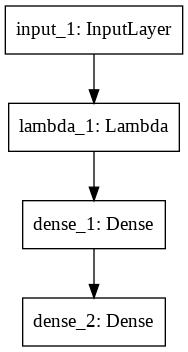

In [ ]:
from keras.utils import plot_model
plot_model(model)

## Training the text classification model

We train our model as usual, calling the _fit_ function of the Keras model.

In [ ]:
history=model.fit(train_features,train_labels,epochs=5,batch_size=16,validation_data=(val_features,val_labels))

Train on 600 samples, validate on 200 samples
Epoch 1/5
600/600 [==============================] - 162s 269ms/step - loss: 0.1384 - categorical_accuracy: 0.9683 - val_loss: 7.8555e-04 - val_categorical_accuracy: 1.0000
Epoch 2/5
600/600 [==============================] - 142s 236ms/step - loss: 4.0585e-04 - categorical_accuracy: 1.0000 - val_loss: 1.9924e-04 - val_categorical_accuracy: 1.0000
Epoch 3/5
600/600 [==============================] - 137s 228ms/step - loss: 1.6538e-04 - categorical_accuracy: 1.0000 - val_loss: 1.1563e-04 - val_categorical_accuracy: 1.0000
Epoch 4/5
600/600 [==============================] - 135s 225ms/step - loss: 4.9852e-05 - categorical_accuracy: 1.0000 - val_loss: 1.6059e-05 - val_categorical_accuracy: 1.0000
Epoch 5/5
600/600 [==============================] - 131s 218ms/step - loss: 1.0015e-05 - categorical_accuracy: 1.0000 - val_loss: 5.0180e-06 - val_categorical_accuracy: 1.0000


Once the model is trained, we evaluate as usual

In [ ]:
model.evaluate(val_features,val_labels)

200/200 [==============================] - 34s 169ms/step


[3.6256938437873032e-06, 1.0]

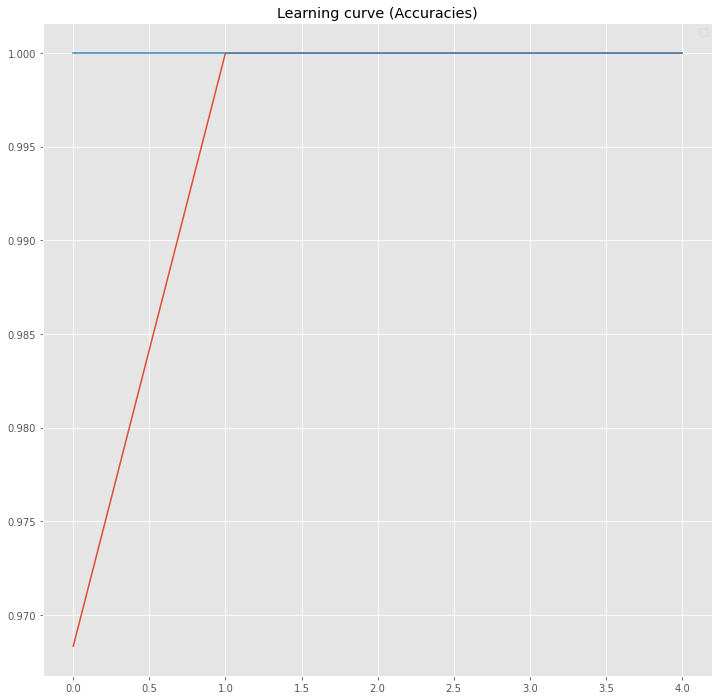

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use("ggplot")
hist = pd.DataFrame(history.history)
plt.figure(figsize=(12,12))
plt.plot(hist["categorical_accuracy"])
plt.plot(hist["val_categorical_accuracy"])
plt.title("Learning curve (Accuracies)")
plt.legend()
plt.show()

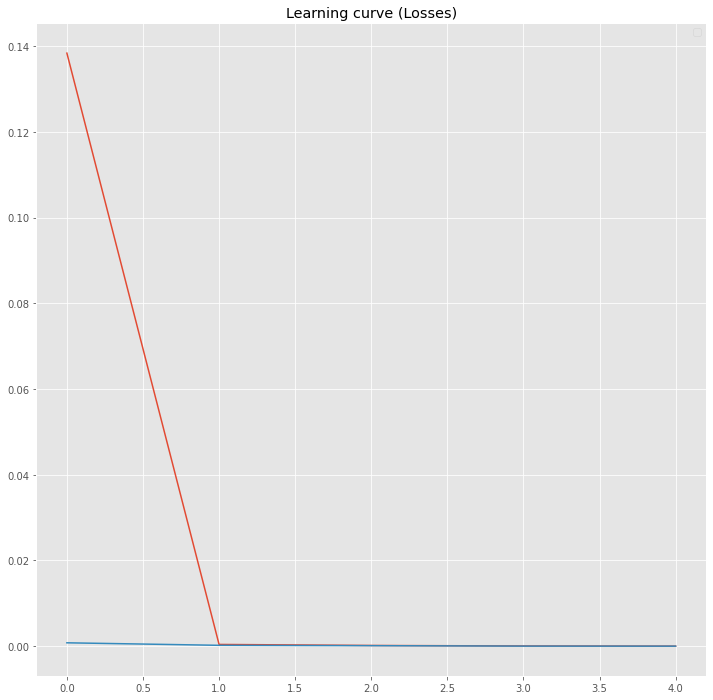

In [ ]:
hist = pd.DataFrame(history.history)
plt.figure(figsize=(12,12))
plt.plot(hist["loss"])
plt.plot(hist["val_loss"])
plt.title("Learning curve (Losses)")
plt.legend()
plt.show()

Opposite to the case of the RNN, where we train our embeddings from scratch and obtained subpar results; in this case we reach a 100% accuracy at the first epoch, thanks to the use of the external ElmO embeddings. The main downside of this approach is the computational cost it requires: as ElmO embeddings have a dimension of 1024, it requires quite a big amount of memory, and so the size of the classifier, as well as the batch size, need to be smaller in order not to overflow the available memory.

## Evaluating over unseen data

As ElmO can generate representations for unseen data, we can use this feature to predict over unseen input reviews. In this case, we will try to predict the genre of the film 'The Hitman's Bodyguard' from its abstract:

In [ ]:
new_plot="""Michael Bryce (Ryan Reynolds) lives a stylish life as an elite UK-based private bodyguard, until client Takashi Kurosawa is assassinated on his watch. Two years later, the disgraced Bryce ekes out a living protecting drug-addicted corporate executives in London.

Meanwhile, Vladislav Dukhovich (Oldman), the ruthless dictator of Belarus is on trial for crimes against humanity at the International Criminal Court. Unable to secure solid evidence or testimony against Dukhovich, the prosecution's last hope is notorious incarcerated hitman Darius Kincaid (Jackson), who agrees to testify against Dukhovich in exchange for the release of his wife Sonia (Hayek) from prison.

Dukhovich's men track Kincaid and eliminate the attackers but their vehicle is destroyed. The two hitchhike to a ferry to Amsterdam, where Sonia is being held. Kincaid reveals that he killed Kurosawa, having spotted him by chance while on another job. As Bryce bemoans his failures at a beer stand, Dukhovich's men attack Kincaid. Bryce has a change of heart and helps Kincaid escape, but is captured. As Dukhovich's men torture him, Kincaid arrives and rescues Bryce. After settling their differences, the two battle their way to The Hague, arriving just in time for Kincaid to testify that Dukhovich tried to hire him to assassinate a political rival, but in the process Kincaid witnessed Dukhovich carry out a mass execution, and uploaded photos of the massacre to a secret FTP site that he provides to the court.

Dukhovich admits guilt, then resorts to his backup plan: bombing the court to escape. Foucher leaves the court before the bombing; Roussel deduces he was the traitor. In the confusion after the bomb went off, Dukhovich seizes a gun to kill Kincaid, but Bryce jumps in the path of the bullet, telling Kincaid to stop Dukhovich. Foucher and Roussel fight. Bryce shoots Foucher to save Roussel; she subdues Foucher. Kincaid pursues Dukhovich to the roof, where he attempts to escape by helicopter. Kincaid destroys the helicopter and kicks Dukhovich off the roof to his death for shooting Bryce.

Kincaid is rearrested for his various crimes, but breaks out of HMP Belmarsh several months later so he and Sonia can celebrate their anniversary in the bar in Honduras where they first met. As a wild bar brawl breaks out around them, the two kiss. """


In order to meet the input constraints of the network, we need to convert our input into a numpy array

In [ ]:
new_plot=np.array(new_plot)
new_plot=np.expand_dims(new_plot,axis=0)

Finally, we can input the embedded plot into the net to predict the label 

In [ ]:
predictions=model.predict(new_plot)
print(id2str[np.argmax(predictions)])

western
